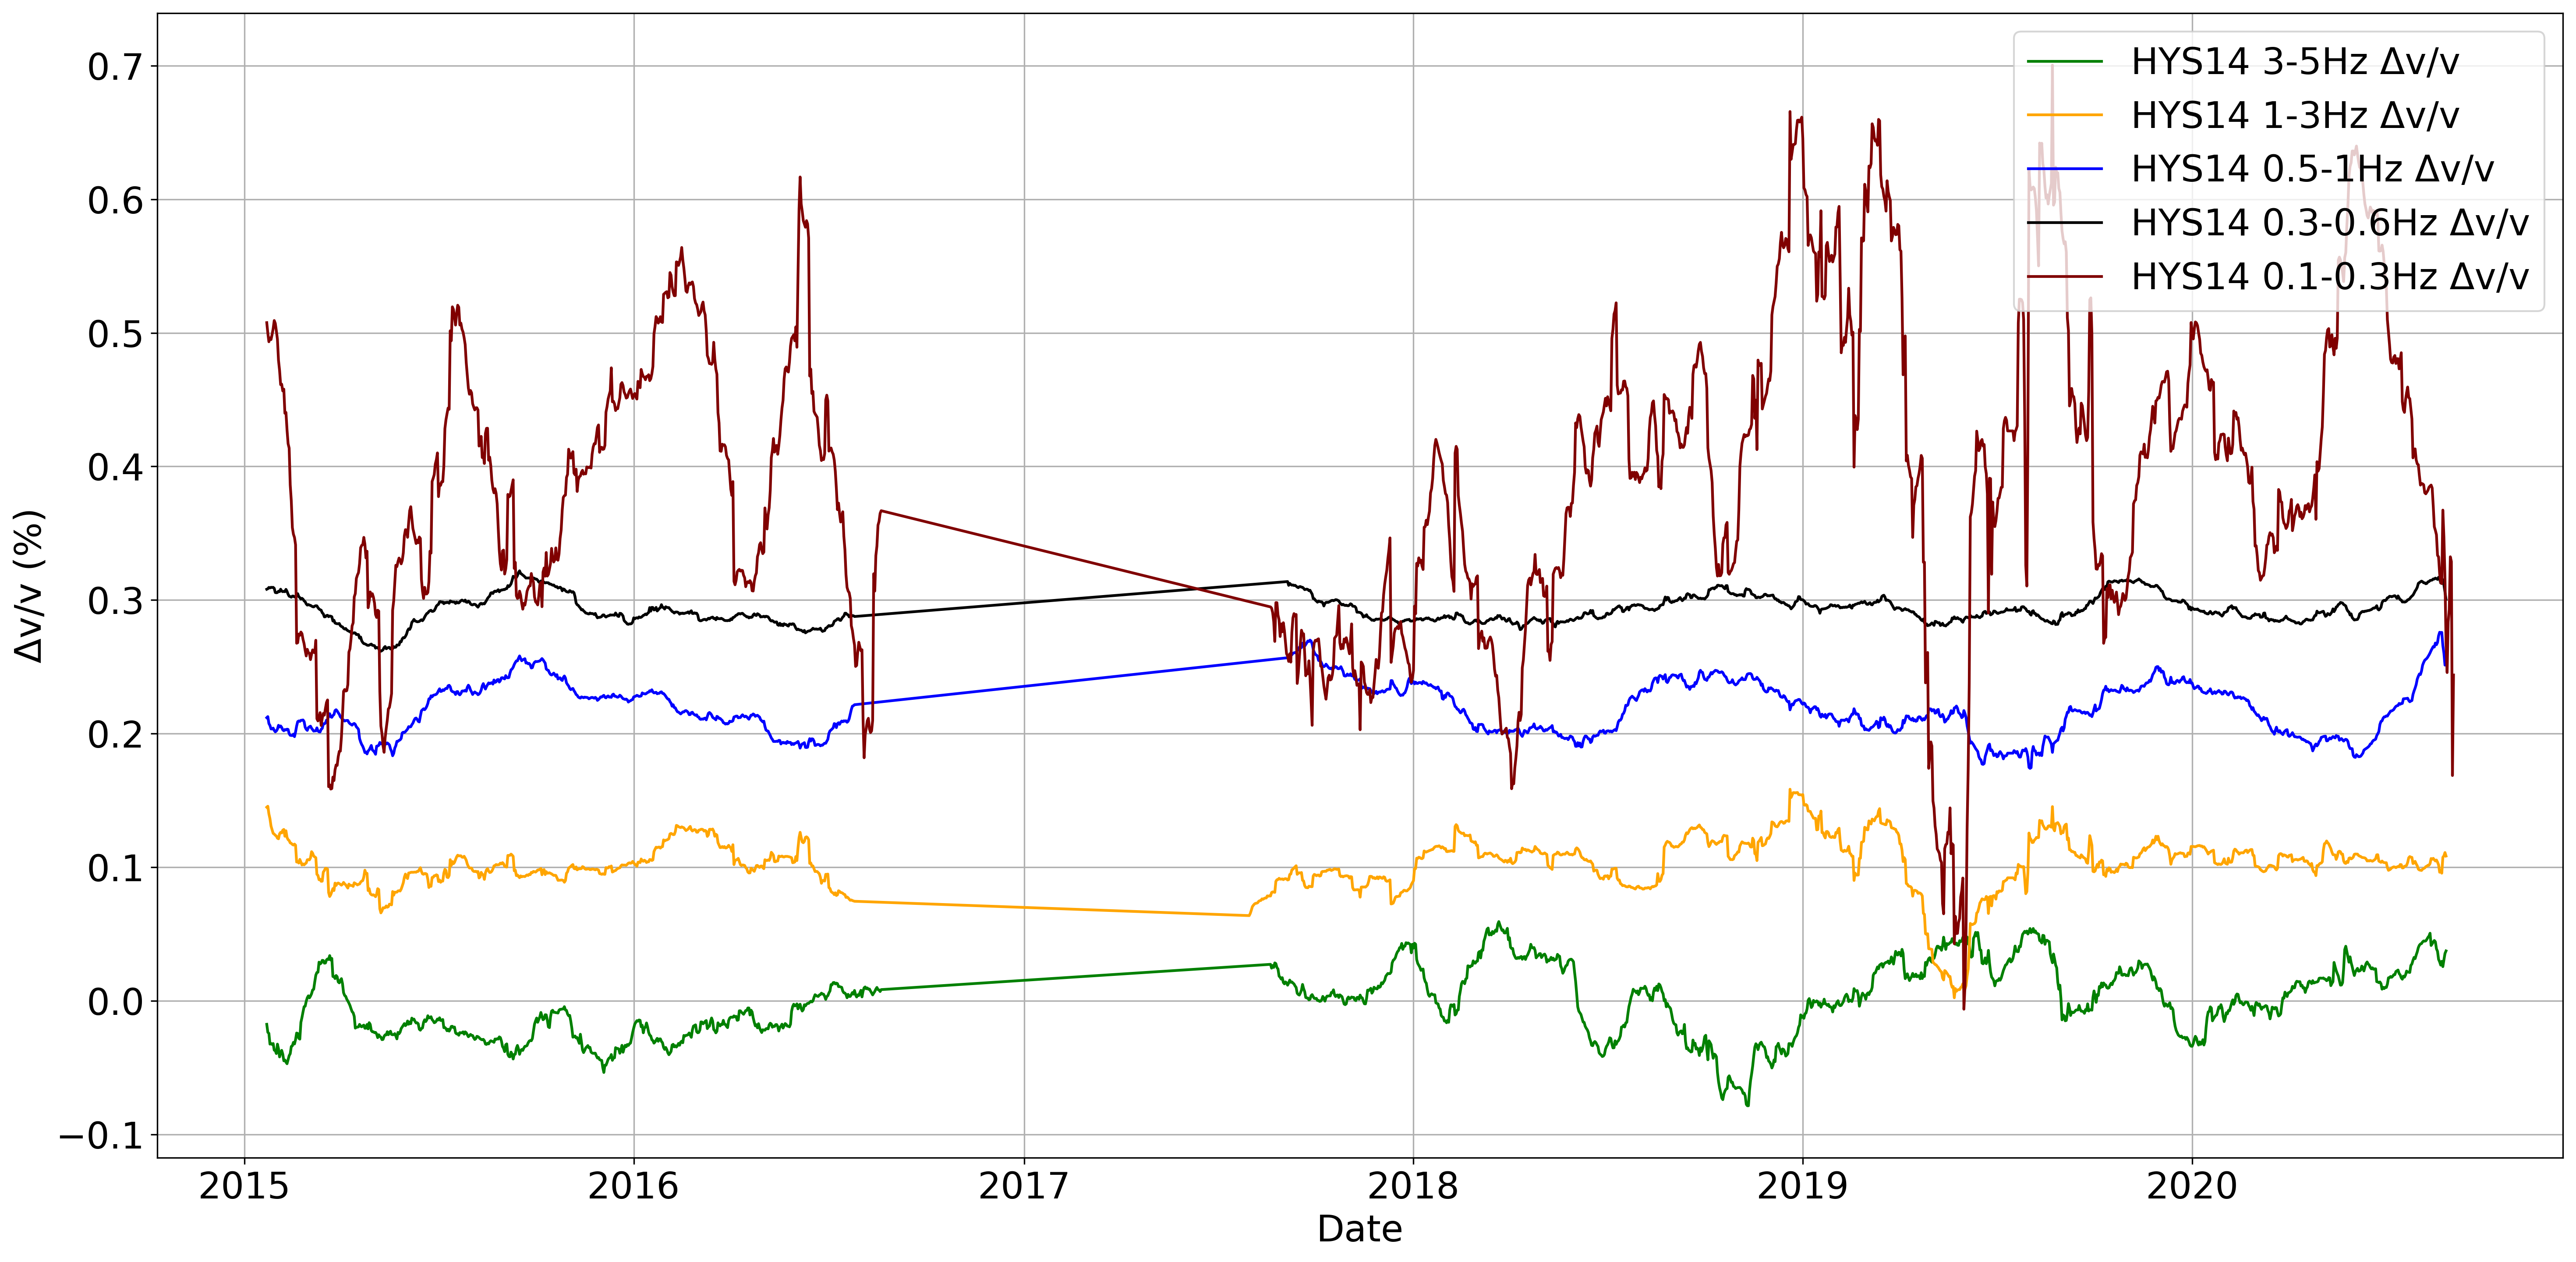

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the paths to your CSV files for all datasets
file_paths = {
    'HYS14 3-5Hz Δv/v': ['HYS14_35ZEp3.csv', 'HYS14_35ZEn3.csv'],
    'HYS14 1-3Hz Δv/v': ['HYS14_13ZEp.csv', 'HYS14_13ZEn.csv'],
    'HYS14 0.5-1Hz Δv/v': ['HYS14_051ZEp.csv', 'HYS14_051ZEn.csv'],
    'HYS14 0.3-0.6Hz Δv/v': ['HYS14_0306ZEp.csv', 'HYS14_0306ZEn.csv'],
    'HYS14 0.1-0.3Hz Δv/v': ['HYS14_0103ZEp.csv', 'HYS14_0103ZEn.csv']
}

# Define the multipliers for each dataset
multipliers = {
    'HYS14 3-5Hz Δv/v': [-1, 1],
    'HYS14 1-3Hz Δv/v': [1, 1],
    'HYS14 0.5-1Hz Δv/v': [1, 1],
    'HYS14 0.3-0.6Hz Δv/v':[1, 1],
    'HYS14 0.1-0.3Hz Δv/v': [-1, 1]
}

# Define offsets for each dataset
offsets = {
    'HYS14 3-5Hz Δv/v': 20,
    'HYS14 1-3Hz Δv/v': 20,
    'HYS14 0.5-1Hz Δv/v': 20,
    'HYS14 0.3-0.6Hz Δv/v': 20,
    'HYS14 0.1-0.3Hz Δv/v': 20
}

# Define exclusion ranges for each dataset
exclude_ranges = {
    'HYS14 3-5Hz Δv/v': [("2017-03-01", "2017-07-30"), ("2016-08-01", "2017-03-16"), ("2020-08-07", "2021-03-16")],
    'HYS14 1-3Hz Δv/v': [("2017-02-15", "2017-07-10"), ("2016-07-07", "2017-03-16"), ("2020-08-07", "2021-03-16")],
    'HYS14 0.5-1Hz Δv/v':[("2017-02-15", "2017-08-15"), ("2016-07-07", "2017-03-18"), ("2020-08-07", "2021-03-16")],
    'HYS14 0.3-0.6Hz Δv/v': [("2017-02-15", "2017-08-15"), ("2016-07-07", "2017-03-18"), ("2020-08-07", "2021-03-16")],
    'HYS14 0.1-0.3Hz Δv/v': [("2017-03-01", "2017-07-30"), ("2016-08-01", "2017-03-16")]
}

plt.rcParams.update({'font.size': 20})

# Setup the main plot
fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
colors = ['green', 'orange', 'blue', 'black', 'maroon']  # Colors for each dataset

# Loop through each dataset
for i, (label, paths) in enumerate(file_paths.items()):
    dataframes = []
    for path, multiplier in zip(paths, multipliers[label]):
        # Load and process data
        df = pd.read_csv(path)
        df['DVT'] *= multiplier  # Apply multiplier
        df['T'] = pd.to_datetime(df['T'])
        df.set_index('T', inplace=True)
        dataframes.append(df)

    # Create a unified time index
    unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))
    interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

    # Exclude specified date ranges
    for start, end in exclude_ranges[label]:
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)
        for j in range(len(interpolated_dfs)):
            interpolated_dfs[j] = interpolated_dfs[j].drop(interpolated_dfs[j].loc[start_date:end_date].index)

    # Calculate weighted Δv/v for the current dataset
    CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)
    weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

    # Create a DataFrame for weighted Δv/v
    weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])
    weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=offsets[label])

    # Plot the weighted Δv/v on the main plot
    ax.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v']+0.1*i, color=colors[i], label=label)

# Finalize plot
ax.set_xlabel('Date')
ax.set_ylabel('Δv/v (%)')
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
plt.show()
